# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction         
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)


def batch_simulator(prior_samples, n_obs):   
    """
    Simulate multiple conversion model datasets via analytical solution of ODE
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²)
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = None
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './CR3_4ACB_[64,64,64]_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./CR3_4ACB_[64,64,64]_ckpts\ckpt-300


### Online training

In [9]:
%%time
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=128, n_obs=n_obs)

Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 13.6 s


## Computational faithfulness

In [9]:
param_prior = prior(1) 
x_data = batch_simulator(param_prior, n_obs)
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior
param_prior[0]

array([-0.69585454, -0.49500403], dtype=float32)

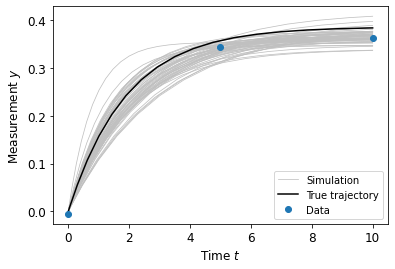

In [10]:
# Posterior predictive check
fig = plt.figure(figsize=(6, 4))
plt.rcParams['font.size'] = 12

for k in range(50):
    rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    if k == 0:
        plt.plot(sol.t, sol.y[1], color='silver', label='Simulation', linewidth=0.75)
    else: 
        plt.plot(sol.t, sol.y[1], color='silver', linewidth=0.75)

rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
plt.plot(time_points, x_data[0], 'o', label='Data')

plt.xlabel('Time $t$')
plt.ylabel('Measurement $y$')
plt.legend(fontsize=10)
plt.show()

In [11]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

def likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta)
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(time_points)
    residual = (x_data[0] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(x,y) * prior_eval(x,y)

In [13]:
# scaling factor
scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)
print(scaling_factor)

# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]
posterior_eval = lambda theta: posterior_xy(theta[0], theta[1])
posterior_at_prior = posterior_eval(param_prior[0])
print(posterior_at_prior)

(336.2389943680486, 1.2373077783678355e-05)
17.940596952740204


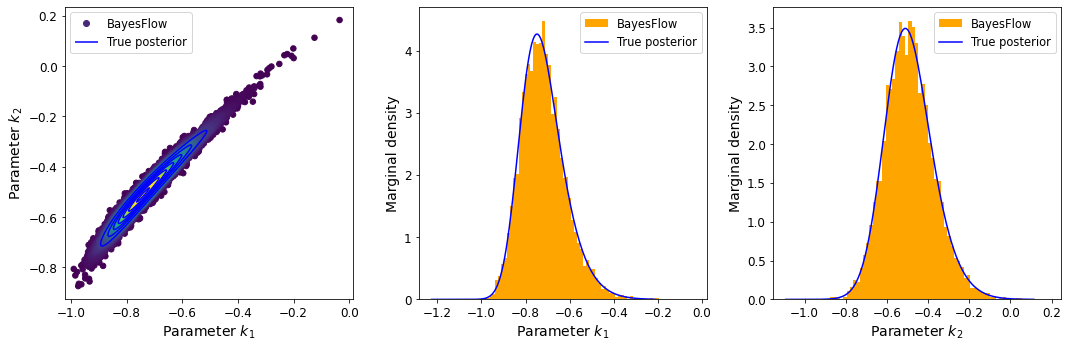

In [14]:
# Plot analytic vs. approximate posterior
plot_posterior(param_samples=param_samples, posterior_xy=posterior_xy)

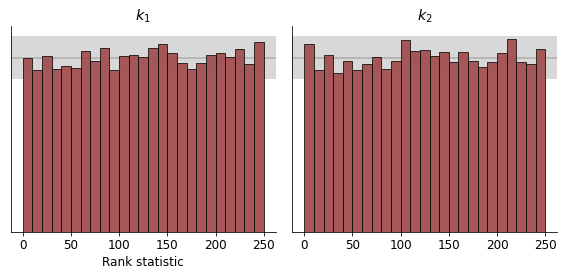

In [15]:
# Simulation-based calibration
n_sbc = 10000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$k_1$', '$k_2$'])

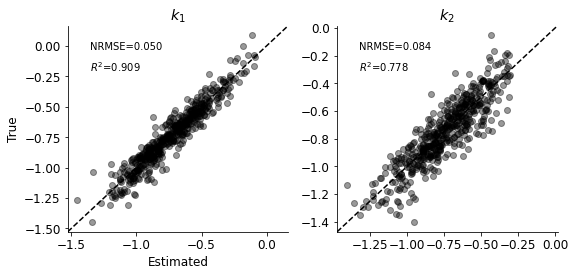

In [16]:
# Validation metrics
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$k_1$', '$k_2$'])